<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/dj_EmotionClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


## Классификация эмоций

используется внутренний датасет

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import json
import torch

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 32.5 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 596 kB 26.0 MB/s 
     |████████████████████████████████| 6.6 MB 60.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
with open("/content/drive/My Drive/clusterdata/emo_classification_v02.json", "r") as read_it: # emo_classification_v01.json
     data = json.load(read_it)

In [ ]:
data['intents'].keys()

dict_keys(['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'])

In [ ]:
# data['intents']['anger']['includes']
#dct = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4:'neutral', 5:'sadness', 6:'surprise'}

In [ ]:
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertTokenizer
# BertForSequenceClassification, AdamW, BertConfig, BertTokenizer

print('Loading BERT tokenizer...')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


#model = BertForSequenceClassification.from_pretrained(
#    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#    num_labels = 7,
#    output_attentions = False, # Whether the model returns attentions weights.
#    output_hidden_states = False, # Whether the model returns all hidden-states.
#)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 7, output_attentions = False, output_hidden_states = False)

model.cuda();

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

In [ ]:
# тут нет длинных предложений - а раньше были

max_len = 0

for sent in data['intents']['anger']['includes']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    if (len(input_ids) == 42):
      print (sent)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

i rin dahil bakit ako magtatanim ng sama ng loob magkakaroon ng feeling na hateful sa isang tao alam mo yun dahil sa kanya
Max sentence length:  42


## Подготовка датасета

Тут есть константа max_length = 128, по которой обрезаем длинные предложения

In [ ]:
input_ids = []
attention_masks = []
labels = []
max_length = 0

for t, y in enumerate(['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']):
  print(t, y)
  for sent in data['intents'][y]['includes']:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # Pad & truncate all sentences. - ВНИМАТЕЛЬНО - ВСЁ БУДЕТ ТАКОЙ ДЛИНЫ!!!
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    if encoded_dict['input_ids'].shape[1] > max_length:
      max_length = encoded_dict['input_ids'].shape[1] # длина текста

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    labels.append(t)

print (max_length)

0 anger


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1 disgust
2 fear
3 happiness
4 neutral
5 sadness
6 surprise
60


In [ ]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print (input_ids.shape, attention_masks.shape, labels.shape)

torch.Size([87940, 60]) torch.Size([87940, 60]) torch.Size([87940])


In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
train_size = int(0.878 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

77,211 training samples
10,729 validation samples


In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, #  default is 5e-5
                  eps = 1e-8 #  default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 256 # 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 6

total_steps = len(train_dataloader) * epochs # [number of batches] x [number of epochs]. !=  the number of training samples

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
device='cuda'
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
dct = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4:'neutral', 5:'sadness', 6:'surprise'}

1e-05

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


seed_val = 42 # Random_seed
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = [] # training and validation loss, validation accuracy, and timings.
total_t0 = time.time() # Measure the total training time for the whole run.

for epoch_i in range(0, epochs):

    # ========= Training =====================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time() # Measure how long the training epoch takes.
    total_train_loss = 0 # Reset the total loss for this epoch.

    model.train() # training mode

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0: # Progress update every 40 batches.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad() # clear any previously calculated gradients

        # Perform a forward pass
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        an = model(b_input_ids,
                             # для distillbert убрал token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss, logits = an['loss'], an['logits']

        total_train_loss += loss.item()

        loss.backward() # Perform a backward pass

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step() # Update parameters

        scheduler.step() # Update the learning rate.

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ==========  Validation ===========

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval() # evaluation mode

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    a_ = [] # NEW
    y_ = [] # NEW

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # not to bother with constructing the compute graph
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            an = model(b_input_ids,
                                   #  для distillbert убрал token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss, logits = an['loss'], an['logits']

        total_eval_loss += loss.item() # Accumulate the validation loss.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        a_.append(logits) # NEW
        y_.append(label_ids) # NEW

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    t1 = [dct[q] for q in np.concatenate(y_)] # NEW
    t2 = [dct[q] for q in np.argmax(np.concatenate(a_), axis=1)] # NEW
    print (classification_report(t1, t2))
    print (f"\n lr = {optimizer.state_dict()['param_groups'][0]['lr']} \n")
    print (confusion_matrix(t1, t2))


print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

#  Batch    40  of  10,521.    Elapsed: 0:00:27.
#  Batch    80  of  10,521.    Elapsed: 0:00:54.

# Batch    40  of    151.    Elapsed: 0:01:27.


======== Epoch 1 / 6 ========
Training...
  Batch    40  of    302.    Elapsed: 0:00:43.
  Batch    80  of    302.    Elapsed: 0:01:25.
  Batch   120  of    302.    Elapsed: 0:02:08.
  Batch   160  of    302.    Elapsed: 0:02:50.
  Batch   200  of    302.    Elapsed: 0:03:32.
  Batch   240  of    302.    Elapsed: 0:04:15.
  Batch   280  of    302.    Elapsed: 0:04:57.

  Average training loss: 0.65
  Training epcoh took: 0:05:20

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.44
  Validation took: 0:00:16
              precision    recall  f1-score   support

       anger       0.95      0.83      0.88      1848
     disgust       0.33      0.07      0.11       287
        fear       0.92      0.82      0.87      1857
   happiness       0.93      0.91      0.92      1835
     neutral       0.58      0.89      0.70      1279
     sadness       0.95      0.92      0.94      1868
    surprise       0.80      0.83      0.81      1755

    accuracy                           0.

## Выводим статистику

In [ ]:
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.65,0.44,0.85,0:05:20,0:00:16
2,0.42,0.41,0.85,0:05:19,0:00:16
3,0.39,0.39,0.86,0:05:19,0:00:16
4,0.37,0.39,0.86,0:05:19,0:00:16
5,0.36,0.38,0.86,0:05:19,0:00:16
6,0.35,0.38,0.86,0:05:19,0:00:16


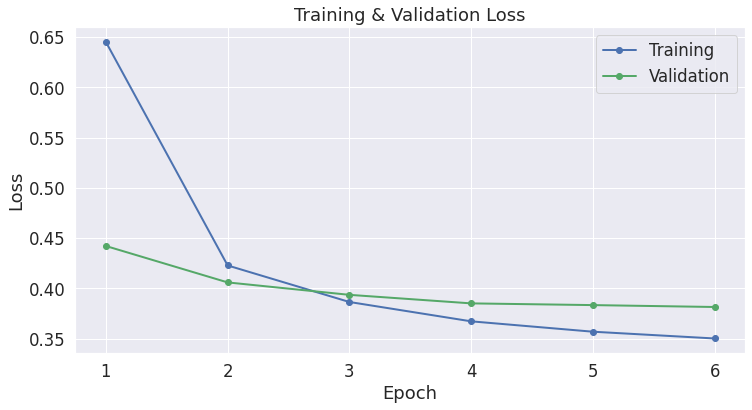

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training", lw=2)
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation", lw=2)

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6])

plt.show()

## Просто получение ответов

In [ ]:
model.eval() # evaluation mode

a_ = []
y_ = []

for batch in validation_dataloader:

  # Unpack this training batch from our dataloader.
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  # not to bother with constructing the compute graph
  with torch.no_grad():
    # Forward pass, calculate logit predictions.
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    an = model(b_input_ids,
               token_type_ids=None,
               attention_mask=b_input_mask,
               labels=b_labels)
    loss, logits = an['loss'], an['logits']

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    a_.append(logits)
    y_.append(label_ids)

In [ ]:
np.concatenate(y_).shape, np.concatenate(a_).shape

((84166,), (84166, 7))

In [ ]:
print (classification_report(np.concatenate(y_), np.argmax(np.concatenate(a_), axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     12303
           1       0.30      0.26      0.28       551
           2       0.97      0.78      0.86      9985
           3       0.97      0.97      0.97     30411
           4       0.58      0.54      0.56      2309
           5       0.95      0.98      0.97     24810
           6       0.70      0.88      0.78      3797

    accuracy                           0.92     84166
   macro avg       0.77      0.76      0.76     84166
weighted avg       0.92      0.92      0.92     84166



In [ ]:
# чтобы были названия классов
dct = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4:'neutral', 5:'sadness', 6:'surprise'}

t1 = [dct[q] for q in np.concatenate(y_)]
t2 = [dct[q] for q in np.argmax(np.concatenate(a_), axis=1)]

In [ ]:
print (classification_report(t1, t2))

              precision    recall  f1-score   support

       anger       0.89      0.91      0.90     12303
     disgust       0.30      0.26      0.28       551
        fear       0.97      0.78      0.86      9985
   happiness       0.97      0.97      0.97     30411
     neutral       0.58      0.54      0.56      2309
     sadness       0.95      0.98      0.97     24810
    surprise       0.70      0.88      0.78      3797

    accuracy                           0.92     84166
   macro avg       0.77      0.76      0.76     84166
weighted avg       0.92      0.92      0.92     84166



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(t1, t2)

array([[11160,    71,    68,   152,   192,   607,    53],
       [  120,   144,    47,    38,   110,    53,    39],
       [  655,    55,  7802,    86,    73,   460,   854],
       [  106,    27,    31, 29594,   248,    83,   322],
       [  334,   101,    55,   367,  1238,    90,   124],
       [  113,    51,    34,    80,    91, 24406,    35],
       [   67,    26,    29,   136,   193,    15,  3331]])

In [ ]:
# сохранить модель
model.save_pretrained("/content/drive/My Drive/clusterdata/emotionmodel2")

In [ ]:
!nvidia-smi # -i 3

Tue Jul 19 10:43:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   6430MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
training_stats

# [{'Training Loss': 0.21920764472429308,
#   'Training Time': '1:53:50',
#   'Valid. Accur.': 0.9239436842772077,
#   'Valid. Loss': 0.17502282430284408,
#   'Validation Time': '0:10:29',
#   'epoch': 1},
#  {'Training Loss': 0.15717326996784567,
#   'Training Time': '1:53:48',
#   'Valid. Accur.': 0.9245850753832511,
#   'Valid. Loss': 0.17805435672811207,
#   'Validation Time': '0:10:31',
#   'epoch': 2}]

[{'Training Loss': 0.6452414427964103,
  'Training Time': '0:05:20',
  'Valid. Accur.': 0.8452325068976088,
  'Valid. Loss': 0.44225756114437464,
  'Validation Time': '0:00:16',
  'epoch': 1},
 {'Training Loss': 0.42291616041533997,
  'Training Time': '0:05:19',
  'Valid. Accur.': 0.8545790063611282,
  'Valid. Loss': 0.40604905642214273,
  'Validation Time': '0:00:16',
  'epoch': 2},
 {'Training Loss': 0.3865700200298764,
  'Training Time': '0:05:19',
  'Valid. Accur.': 0.8558719088493767,
  'Valid. Loss': 0.3936861753463745,
  'Validation Time': '0:00:16',
  'epoch': 3},
 {'Training Loss': 0.3673334087164986,
  'Training Time': '0:05:19',
  'Valid. Accur.': 0.8572853598252606,
  'Valid. Loss': 0.38518722710155306,
  'Validation Time': '0:00:16',
  'epoch': 4},
 {'Training Loss': 0.3570111956422692,
  'Training Time': '0:05:19',
  'Valid. Accur.': 0.8584852563611282,
  'Valid. Loss': 0.38347849817503066,
  'Validation Time': '0:00:16',
  'epoch': 5},
 {'Training Loss': 0.35027570469884

## Если взять готовую модель

https://huggingface.co/j-hartmann/emotion-english-distilroberta-base

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)
classifier("I love this!")

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


[{'label': 'anger', 'score': 0.004419783595949411},
 {'label': 'disgust', 'score': 0.0016119909705594182},
 {'label': 'fear', 'score': 0.00041385195800103247},
 {'label': 'joy', 'score': 0.9771687984466553},
 {'label': 'neutral', 'score': 0.005764586851000786},
 {'label': 'sadness', 'score': 0.002092393347993493},
 {'label': 'surprise', 'score': 0.008528684265911579}]

In [ ]:
# classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")
classifier("I love this!")[0]['label']

'joy'

In [ ]:
ys = []
labels2 = []


for t, y in enumerate(['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']):
  print(t, y)
  for sent in data['intents'][y]['includes']:
    ys.append(classifier(sent)[0]['label'])
    labels2.append(y)


0 anger
1 disgust
2 fear
3 happiness
4 neutral
5 sadness
6 surprise


In [ ]:
import pandas as pd

In [ ]:
tmp = pd.DataFrame({'y': labels2, 'a':ys})

In [ ]:
pd.crosstab(tmp.y, tmp.a)

a,anger,disgust,fear,joy,neutral,sadness,surprise
y,,,,,,,
anger,12794,389,403,204,634,440,136
disgust,235,774,158,77,690,344,226
fear,627,276,12649,127,220,220,881
happiness,168,55,119,13386,530,434,308
neutral,774,1063,352,609,6181,635,1184
sadness,579,35,381,212,128,13618,47
surprise,350,292,1225,839,1174,144,10614


In [ ]:
tmp.a.unique()

array(['anger', 'neutral', 'fear', 'sadness', 'disgust', 'joy',
       'surprise'], dtype=object)

In [ ]:
dct1 = {'anger':0, 'disgust':1, 'fear':2, 'happiness':3, 'neutral':4, 'sadness':5, 'surprise':6}
dct2 = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}

print (classification_report(tmp.y.map(dct1), tmp.a.map(dct2)))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84     15000
           1       0.27      0.31      0.29      2504
           2       0.83      0.84      0.84     15000
           3       0.87      0.89      0.88     15000
           4       0.65      0.57      0.61     10798
           5       0.86      0.91      0.88     15000
           6       0.79      0.73      0.76     14638

    accuracy                           0.80     87940
   macro avg       0.73      0.73      0.73     87940
weighted avg       0.80      0.80      0.79     87940

